Variational Autoencoder
======================
Classe de modelos generativos que combina conceitos de aprendizado profundo e estatística bayesiana para aprender representações latentes contínuas de dados, permitindo a geração de novos exemplos semelhantes aos dados de treinamento.

1 Autoencoder
--------------

Um autoencoder tradicional é uma rede neural que consiste em duas partes principais:

* Encoder: Mapeia os dados de entrada para um espaço latente de dimensão inferior.
* Decoder: Reconstrói os dados originais a partir da representação latente.

O objetivo do autoencoder é comprimir os dados e, em seguida, reconstruí-los da forma mais fiel possível.

**Limitações do autoencoder**

* Embora um autoencoder possa aprender boas representações latentes dos dados, ele não é projetado para gerar novas amostras do espaço latente. A representação latente pode ser irregular, e pequenas variações no espaço latente podem levar a grandes alterações nas amostras reconstruídas.

2 Variabilidade (probabilidade)
--------------------------------

O VAE introduz um componente probabilístico no processo, onde em vez de mapear uma entrada para um único ponto no espaço latente, ele mapeia para uma distribuição (tipicamente uma distribuição normal).

Em termos práticos, o encoder de um VAE não gera diretamente a representação latente (`z`), mas gera parâmetros de uma distribuição (a média $\mu$ - `mu` e o log da variância `logvar`), de onde `z` será amostrado.

3 Reparametrização
-------------------
Para garantir que o processo de amostragem de `z` seja diferenciável (necessário para treinar a rede usando retropropagação), o VAE utiliza um truque chamado reparametrização.
O vetor latente `z` é obtido combinando a média `mu`, a variância `logvar`, e um vetor de ruído `epsilon`:

$ z = \mu + \sigma * \epsilon$

onde,

* sigma é a raiz quadrada da variância;7
* epsilon é amostrado de uma distribuição normal padrão.


4 Decoder como gerador
----------------------
O decoder do VAE recebe `z` (amostrado da distribuição latente) e tenta reconstruir a entrada original. Como `z` é amostrado de uma distribuição normal, podemos amostrar diferentes `z` para gerar novas amostras, o que transforma o decoder em um gerador.

5 Função de perda do VAE
-----------------------

A função de perda do VAE é composta por dois termos principais:

* **Reconstrução (Reconstruction Loss):** Mede o quão bem o decoder consegue reconstruir a entrada original a partir do vetor `z`. Isso geralmente é calculado como a entropia cruzada entre os dados reais e os reconstruídos.
* **Divergência de Kullback-Leibler (KL Divergence):** Mede o quão próxima a distribuição latente aprendida (definida por `mu` e `logvar`) está de uma distribuição normal padrão (distribuição-alvo). Essa regularização incentiva o espaço latente a ser contínuo e permite a geração de novas amostras ao decodificar `z` amostrados de uma distribuição normal padrão.

6 Vantagens do VAE
-------------------

* **Geração de Dados:** O VAE pode gerar novos dados que se parecem com os dados de treinamento, mas são amostras novas.
* **Espaço Latente Contínuo:** O espaço latente aprendido pelo VAE é contínuo, o que significa que pequenas variações em z resultam em pequenas variações nos dados gerados.
* **Interpolação:** Por causa da regularização do espaço latente, podemos interpolar entre diferentes pontos latentes e gerar transições suaves entre os exemplos gerados.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

Espaço latente
===============

Espaço latente é um espaço de dimensão reduzida onde os dados são representados de maneira compacta e significativa. Os vetores latentes são pontos neste espaço. Cada vetor latente pode ser mapeado para uma amostra no espaço original dos dados (por exemplo, uma imagem, texto ou som).

Vetor latente
______________

1. **Representação Compacta:** Um vetor latente é uma representação compacta e densa de uma amostra. Por exemplo, uma imagem de alta resolução pode ser representada por um vetor latente de dimensão muito menor do que o número total de pixels da imagem.

2. **Dimensionalidade Reduzida:** O vetor latente possui uma dimensionalidade menor em comparação com os dados originais, o que ajuda a capturar os padrões mais importantes dos dados. Isso significa que o vetor latente retém as informações mais relevantes de maneira condensada.

3. **Entrada para Modelos Geradores:** Em modelos como GANs, o vetor latente serve como entrada para o gerador, que transforma esse vetor em uma amostra do espaço original (como uma imagem, som ou texto). Diferentes vetores latentes podem gerar diferentes amostras, e pequenas mudanças no vetor latente podem resultar em variações na amostra gerada.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Parâmetros
latent_dim = 20  # Dimensão do espaço latente
batch_size = 64
epochs = 20
learning_rate = 0.001
img_shape = (1, 28, 28)

In [ ]:
# Transformação dos dados
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
# Carregar dataset MNIST
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.67MB/s]


In [ ]:
# Definir a arquitetura do VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 400),
            nn.ReLU(),
            nn.Linear(400, 100),
            nn.ReLU()
        )

        # Camadas para a média e log variância
        self.fc_mu = nn.Linear(100, latent_dim)
        self.fc_logvar = nn.Linear(100, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, img_shape)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Divergência de Kullback-Leibler
--------------------------------

A divergência de Kullback-Leibler (KL) é uma medida da teoria da informação que quantifica o quanto uma distribuição de probabilidade diverge de uma segunda distribuição de referência. Também é conhecida como entropia relativa entre duas distribuições.

Dadas duas distribuições de probabilidade $P$ e $Q$ definidas sobre o mesmo espaço de probabilidade, a divergência KL de $Q$ para $Q$ é definida como:

$$D_{KL}(P \parallel Q) = \sum_{x} P(x) \log \frac{P(x)}{Q(x)}$$

Para distribuições contínuas, a soma é substituída por uma integral:

$$D_{KL}(P \parallel Q) = \int_{-\infty}^{\infty} p(x) \log \frac{p(x)}{q(x)} \, dx$$

Onde:

* $P(x)$ é a verdadeira distribuição de probabilidade dos dados (também chamada de distribuição alvo).
* $Q(x)$ é a distribuição aproximada (também chamada de distribuição do modelo).

Interpretação
------------

* **A divergência KL é assimétrica:** $D_{KL} (P || Q)$ não é igual a $D_{KL} (Q || P)$, ou seja, a divergência de $P$ para $Q$ não é a mesma de $Q$ para $P$;
* **Não-negativa:** $D_{KL} (P || Q) \geq 0$  para todas as distribuições $P$ e $Q$, sendo igual a zero se e somente se $P = Q$ quase em toda parte;
* **Não é uma verdadeira distância:** Como a divergência KL é assimétrica, ela não satisfaz a desigualdade triangular e, portanto, não é uma métrica ou distância verdadeira.

Uso
-------
A divergência KL é amplamente utilizada em várias áreas, incluindo:

* **Aprendizado de Máquina:** Em algoritmos como Variational Autoencoders (VAEs), onde é usada como um termo de regularização para medir o quão próxima a distribuição posterior aproximada está da distribuição a priori.
* **Teoria da Informação:** Para quantificar a ineficiência de se assumir que a distribuição $Q$ é verdadeira quando a distribuição real é $P$.
* **Processamento de Linguagem Natural:** Em tarefas como modelagem de tópicos ou na avaliação de quão semelhantes são duas distribuições.

A divergência KL pode ser usada para comparar a similaridade entre duas distribuições, com uma divergência KL menor indicando que as distribuições são mais semelhantes.

In [ ]:
# Função de perda (ELBO - Evidence Lower Bound)
def loss_function(recon_x, x, mu, logvar):
    # Reconstruir x para o intervalo [0, 1]
    x = (x + 1) / 2  # Ajusta os dados de entrada para o intervalo [0, 1]

    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
# Instanciar o modelo e definir o otimizador
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [ ]:
# Função para treinar o VAE
def train_vae(vae, dataloader, optimizer, epochs):
    vae.to(device)
    vae.train()
    for epoch in range(epochs):
        train_loss = 0
        for i, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {train_loss / len(dataloader.dataset):.4f}")

        # Salvar algumas imagens geradas após cada época
        with torch.no_grad():
            z = torch.randn(64, latent_dim).to(device)
            sample = vae.decode(z).cpu()
            img_path = f"images_vae/vae_sample_{epoch}.png"
            save_image(sample.view(64, 1, 28, 28), img_path)
            print(f"Generated image saved to {img_path}")
            # Display the saved image
            from IPython.display import Image, display
            display(Image(filename=img_path))

In [ ]:
# Verificar e criar o diretório 'images' se ele não existir
if not os.path.exists('images_vae'):
    os.makedirs('images_vae')

Epoch [1/20] Loss: 160.9930
Generated image saved to images_vae/vae_sample_0.png


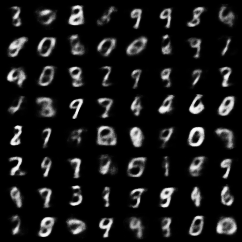

Epoch [2/20] Loss: 124.0489
Generated image saved to images_vae/vae_sample_1.png


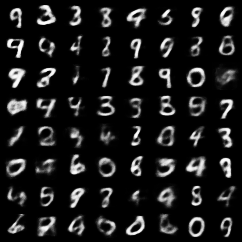

Epoch [3/20] Loss: 116.9353
Generated image saved to images_vae/vae_sample_2.png


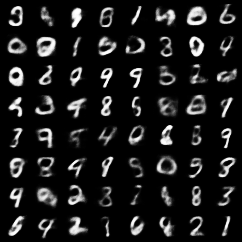

Epoch [4/20] Loss: 113.3116
Generated image saved to images_vae/vae_sample_3.png


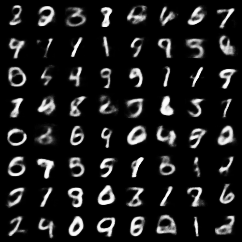

Epoch [5/20] Loss: 111.0882
Generated image saved to images_vae/vae_sample_4.png


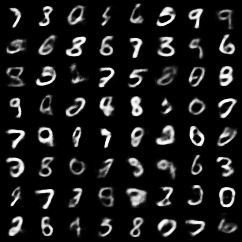

Epoch [6/20] Loss: 109.6570
Generated image saved to images_vae/vae_sample_5.png


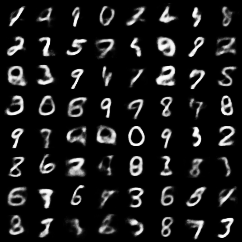

Epoch [7/20] Loss: 108.5238
Generated image saved to images_vae/vae_sample_6.png


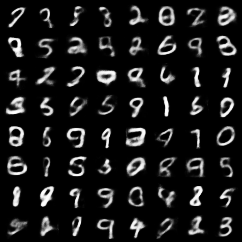

Epoch [8/20] Loss: 107.6752
Generated image saved to images_vae/vae_sample_7.png


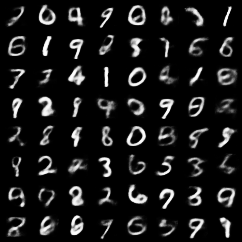

Epoch [9/20] Loss: 106.9928
Generated image saved to images_vae/vae_sample_8.png


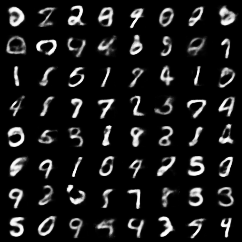

Epoch [10/20] Loss: 106.4548
Generated image saved to images_vae/vae_sample_9.png


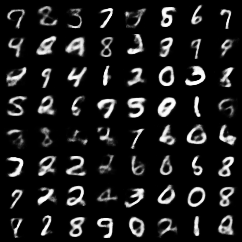

In [ ]:
# Treinar o VAE
train_vae(vae, dataloader, optimizer, epochs)